# Keras integration

This notebook describes the combination of bt_ocean with Keras.

bt_ocean allows a neural network to be used to define a right-hand-side forcing term, which can then be trained using time-dependent data. Here, to demonstrate the principles, we will consider an extremely simple case of a Keras model consisting of a single layer which simply outputs the degrees of freedom for a function &ndash; so that training reduces to the problem of finding this function. Specifically we will try to find the wind forcing term $Q$ used on the right-hand-side of the barotropic vorticity equation. This toy problem demonstrates the key ideas &ndash; while remaining small enough to run quickly!

## Training data

For this simple toy problem we will run a low resolution model for a short amount of time.

In [1]:
%matplotlib inline

from bt_ocean.model import CNAB2Solver
from bt_ocean.network import Dynamics
from bt_ocean.parameters import parameters, tau_0, rho_0, D, Q

import jax
import jax.numpy as jnp
import keras
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)
keras.backend.set_floatx("float64")

n_hour = 2
parameters = dict(parameters)
parameters.update({"N_x": 64,
                   "N_y": 64,
                   "dt": 3600 / n_hour,
                   "nu": 2500})
model = CNAB2Solver(parameters)
model.fields["Q"] = Q(model.grid)

n_day = 24 * n_hour
N = 5 * n_day

model.initialize()
data = [model.fields["zeta"]]
for _ in range(N):
    model.step()
    data.append(model.fields["zeta"])
    if model.n % n_day == 0:
        print(f"{model.n // n_day=} {model.ke()=}")
data = jnp.array(data)

model.n // n_day=1 model.ke()=Array(8.04060177e+08, dtype=float64)


model.n // n_day=2 model.ke()=Array(3.14111617e+09, dtype=float64)


model.n // n_day=3 model.ke()=Array(6.83963961e+09, dtype=float64)


model.n // n_day=4 model.ke()=Array(1.16664391e+10, dtype=float64)


model.n // n_day=5 model.ke()=Array(1.73523662e+10, dtype=float64)


## A simple Keras model

We now set up our Keras model. To do this we first define a `keras.models.Model` which defines a map from our state to a forcing term which we add on the right-hand-side of the barotropic vorticity equation, and a callable which uses this map.

In [2]:
import keras


class Term(keras.layers.Layer):
    def __init__(self, grid, **kwargs):
        super().__init__(**kwargs)
        self.__b = self.add_weight(shape=(grid.N_x + 1, grid.N_y + 1), dtype=grid.fdtype, initializer="zeros")

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + self.__b.shape

    def call(self, inputs):
        return jnp.tensordot(jnp.ones_like(inputs, shape=inputs.shape[:-1]), self.__b, axes=0)


Q_input_layer = keras.layers.Input((0,))
Q_network = keras.models.Model(inputs=Q_input_layer, outputs=Term(model.grid)(Q_input_layer))
Q_weight = tau_0 * jnp.pi / (D * rho_0 * model.grid.L_y)


def update(dynamics, Q_network):
    dynamics.fields["Q"] = Q_weight * Q_network(jnp.zeros(shape=(1, 0)))[0, :, :]

We now set up a `Dynamics` layer. This is a custom Keras layer which represents the mapping from an initial condition, in terms of the initial vorticity fields, to dynamical trajectories, in terms of the vorticity fields evaluated at later times. The trajectories are computed by solving the barotropic vorticity equation, while being forced with an extra right-hand-side term defined by the given `keras.models.Model`.

In the following we use the AdamW optimizer, but here we have only one batch of size one. In fact here we are solving a standard variational optimization problem, but without an explicit regularization term, and so for this problem it might be better to use a deterministic optimizer. We do, however, increase the learning rate.

In [3]:
output_weight = (model.grid.N_x + 1) * (model.grid.N_y + 1) * jnp.sqrt(model.grid.W / (4 * model.grid.L_x * model.grid.L_y)) / (model.beta * model.grid.L_y)
dynamics_input_layer = keras.layers.Input((model.grid.N_x + 1, model.grid.N_y + 1))
dynamics_layer = Dynamics(
    model, update, Q_network, N=1, n_output=N, output_weight=output_weight)
dynamics_network = keras.models.Model(
    inputs=dynamics_input_layer, outputs=dynamics_layer(dynamics_input_layer))
dynamics_network.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.1),
                         loss="mean_squared_error")

## Training

We are now ready to train. In this simple problem we simply use the full trajectory as a single input-output pair, and since we know the answer we supply no validation data.

In [4]:
input_data = jnp.reshape(data[0, :, :], (1,) + data.shape[1:])
output_data = jnp.reshape(data[1:, :, :], (1, data.shape[0] - 1) + data.shape[1:])
_ = dynamics_network.fit(input_data, output_data * output_weight, epochs=40, verbose=2)

Epoch 1/40


1/1 - 2s - 2s/step - loss: 0.0127


Epoch 2/40


1/1 - 0s - 230ms/step - loss: 0.0104


Epoch 3/40


1/1 - 0s - 339ms/step - loss: 0.0082


Epoch 4/40


1/1 - 0s - 274ms/step - loss: 0.0063


Epoch 5/40


1/1 - 0s - 235ms/step - loss: 0.0046


Epoch 6/40


1/1 - 0s - 232ms/step - loss: 0.0032


Epoch 7/40


1/1 - 0s - 208ms/step - loss: 0.0022


Epoch 8/40


1/1 - 0s - 206ms/step - loss: 0.0014


Epoch 9/40


1/1 - 0s - 199ms/step - loss: 8.2696e-04


Epoch 10/40


1/1 - 0s - 215ms/step - loss: 4.9747e-04


Epoch 11/40


1/1 - 0s - 287ms/step - loss: 3.4275e-04


Epoch 12/40


1/1 - 0s - 360ms/step - loss: 3.1915e-04


Epoch 13/40


1/1 - 0s - 206ms/step - loss: 3.8344e-04


Epoch 14/40


1/1 - 0s - 270ms/step - loss: 4.9586e-04


Epoch 15/40


1/1 - 0s - 215ms/step - loss: 6.2267e-04


Epoch 16/40


1/1 - 0s - 206ms/step - loss: 7.3773e-04


Epoch 17/40


1/1 - 0s - 216ms/step - loss: 8.2326e-04


Epoch 18/40


1/1 - 0s - 302ms/step - loss: 8.6954e-04


Epoch 19/40


1/1 - 0s - 223ms/step - loss: 8.7397e-04


Epoch 20/40


1/1 - 0s - 208ms/step - loss: 8.3959e-04


Epoch 21/40


1/1 - 0s - 219ms/step - loss: 7.7340e-04


Epoch 22/40


1/1 - 0s - 226ms/step - loss: 6.8469e-04


Epoch 23/40


1/1 - 0s - 250ms/step - loss: 5.8354e-04


Epoch 24/40


1/1 - 0s - 252ms/step - loss: 4.7961e-04


Epoch 25/40


1/1 - 0s - 219ms/step - loss: 3.8121e-04


Epoch 26/40


1/1 - 0s - 228ms/step - loss: 2.9468e-04


Epoch 27/40


1/1 - 0s - 214ms/step - loss: 2.2413e-04


Epoch 28/40


1/1 - 0s - 217ms/step - loss: 1.7138e-04


Epoch 29/40


1/1 - 0s - 209ms/step - loss: 1.3617e-04


Epoch 30/40


1/1 - 0s - 226ms/step - loss: 1.1656e-04


Epoch 31/40


1/1 - 0s - 214ms/step - loss: 1.0943e-04


Epoch 32/40


1/1 - 0s - 226ms/step - loss: 1.1098e-04


Epoch 33/40


1/1 - 0s - 224ms/step - loss: 1.1733e-04


Epoch 34/40


1/1 - 0s - 214ms/step - loss: 1.2494e-04


Epoch 35/40


1/1 - 0s - 205ms/step - loss: 1.3095e-04


Epoch 36/40


1/1 - 0s - 222ms/step - loss: 1.3341e-04


Epoch 37/40


1/1 - 0s - 217ms/step - loss: 1.3133e-04


Epoch 38/40


1/1 - 0s - 220ms/step - loss: 1.2460e-04


Epoch 39/40


1/1 - 0s - 220ms/step - loss: 1.1387e-04


Epoch 40/40


1/1 - 0s - 214ms/step - loss: 1.0025e-04


Let's see how well we've done.

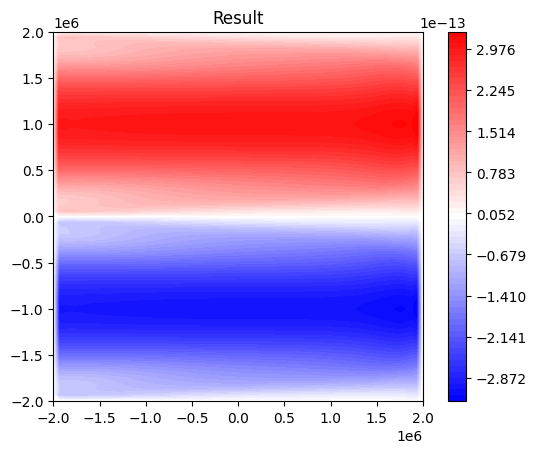

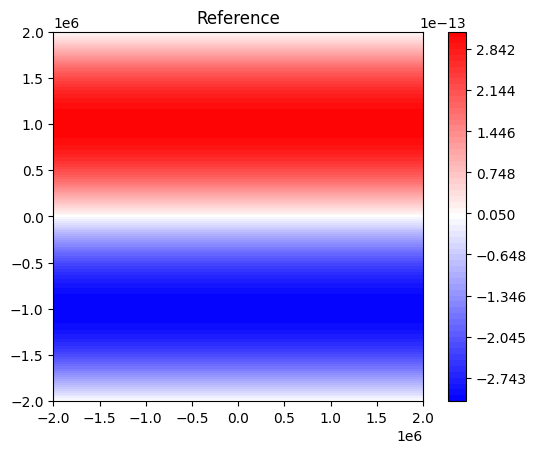

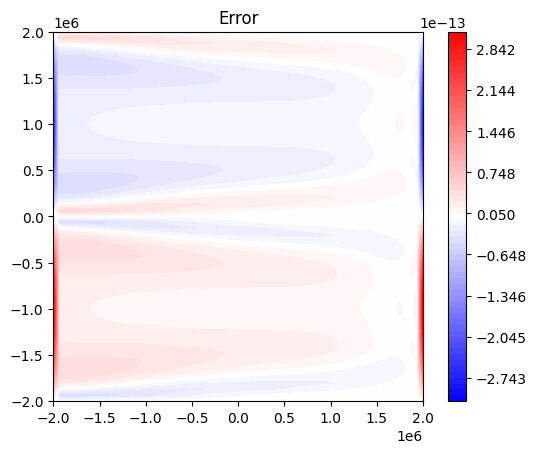

In [5]:
result = Q_weight * dynamics_network.get_weights()[0]
ref = model.fields["Q"]

plt.figure()
m = abs(result).max()
plt.contourf(model.grid.X, model.grid.Y, result,
            jnp.linspace(-m * (1 + 1.0e-10), m * (1 + 1.0e-10), 64), cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.title("Result")

plt.figure()
m = abs(ref).max()
plt.contourf(model.grid.X, model.grid.Y, ref,
            jnp.linspace(-m * (1 + 1.0e-10), m * (1 + 1.0e-10), 64), cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.title("Reference")

plt.figure()
m = abs(result - ref).max()
plt.contourf(model.grid.X, model.grid.Y, result - ref,
            jnp.linspace(-m * (1 + 1.0e-10), m * (1 + 1.0e-10), 64), cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.title("Error")

assert abs((result - ref)[8:-8, 8:-8]).max() < 0.2 * abs(ref[8:-8, 8:-8]).max()

We have a reasonable result, except at the east and west boundaries.

While we might expect to do much better for this problem if we applied a deterministic optimizer, there is also a more fundamental problem here. bt_ocean applies free slip boundary conditions, meaning that the vorticity satisfies homogeneous Dirichlet boundary conditions. This means that there are perturbations we can apply to the right-hand-side (contributions to $Q$) which do not affect the dynamics &ndash; and consequently derivatives of the loss with respect to the right-hand-side forcing, evaluated in directions associated with these perturbations, are zero. This non-regularized inverse problem is ill-posed, and we see this here by finding that, given only the trajectory of the numerical model, we cannot recover the wind stress curl term on the boundary.

## Increasing the complexity

Here we have used Keras to solve a standard variational optimization problem, by defining a very simple Keras model. However we can make the Keras model `Q_network` much more complex, and can also use the `Dynamics` layer itself as part of a more complicated 'outer' Keras model. That is, we can embed neural networks within bt_ocean, and can also embed bt_ocean within neural networks. The main restriction is that use of the embedded neural network (by the `update` callable in this example) can only change the `dynamics` argument, but cannot change other arguments (here `Q_network`) or have other side effects. This means for example that evaluating the embedded neural network cannot change the neural network itself &ndash; as occurs e.g. with batch normalization.